## implementation stollen from https://blog.paperspace.com/beginners-guide-to-boltzmann-machines-pytorch/

In [1]:
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# import torchviz

In [33]:
def show_and_save(file_name,img):
    print(img.shape)
    npimg = np.transpose(img.numpy(),(1,2,0))
    f = "./%s.png" % file_name
    plt.imshow(npimg)
    plt.imsave(f,npimg)

In [34]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
datasets.MNIST('./data',
    train=True,
    download = True,
    transform = transforms.Compose(
        [transforms.ToTensor()])
     ),
     batch_size=batch_size
)

test_loader = torch.utils.data.DataLoader(
datasets.MNIST('./data',
    train=False,
    transform=transforms.Compose(
    [transforms.ToTensor()])
    ),
    batch_size=batch_size)


In [35]:
# this is a descrete RBM
class RBM(nn.Module):
   def __init__(self,
               n_vis,
               n_hin,
               k):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(n_hin,n_vis)*1e-2)
        self.v_bias = nn.Parameter(torch.zeros(n_vis))
        self.h_bias = nn.Parameter(torch.zeros(n_hin))
        self.k = k
    
   def sample_from_p(self,p):
       return torch.relu(torch.sign(p - Variable(torch.rand(p.size()))))

   def v_to_h(self,v):
        p_h      = F.sigmoid(F.linear(v, self.W, self.h_bias))
        sample_h = self.sample_from_p(p_h)
       
        return sample_h
    
   def h_to_v(self,h):
        p_v      = F.sigmoid(F.linear(h, self.W.t(), self.v_bias))
        sample_v = self.sample_from_p(p_v)
       
        return sample_v,p_v

   def forward(self,v):
        h1 = self.v_to_h(v)
        
        h_ = h1
        for _ in range(self.k):
            v_,p_v = self.h_to_v(h_)
            h_     = self.v_to_h(v_)
        
        return v,v_,p_v

   def free_energy(self,v):
        vbias_term = v.mv(self.v_bias)
        wx_b = F.linear(v, self.W, self.h_bias)
        hidden_term = wx_b.exp().add(1).log().sum(1)
        return (-hidden_term - vbias_term).mean()

In [62]:
n_it_training = 3

rbm_mnist = RBM(784, 500, n_it_training)
train_op = optim.SGD(rbm_mnist.parameters(),0.01)
losses=[]

n_epochs, n_batch = 10, 300
for epoch in range(n_epochs):
    loss_ = []
    for i, (data,target) in enumerate(train_loader):
        data = Variable(data.view(-1,784))
        sample_data = data.bernoulli()
        
        v,v1,p_v = rbm_mnist(sample_data)
        loss = rbm_mnist.free_energy(v) - rbm_mnist.free_energy(v1)
        loss_.append(loss.data)
        train_op.zero_grad()
        loss.backward()
        train_op.step()

        if i >= n_batch and n_batch > 0:
            break
        
    losses.append(np.mean(loss_))
    print("Training loss for {} epoch: {}".format(epoch, np.mean(loss_)))


Training loss for 0 epoch: -19.758934020996094
Training loss for 1 epoch: -15.032418251037598
Training loss for 2 epoch: -14.843729019165039
Training loss for 3 epoch: -13.907133102416992
Training loss for 4 epoch: -13.594705581665039
Training loss for 5 epoch: -13.043316841125488
Training loss for 6 epoch: -12.40012264251709
Training loss for 7 epoch: -11.80082893371582
Training loss for 8 epoch: -11.20588207244873
Training loss for 9 epoch: -10.830078125


torch.Size([3, 122, 242])


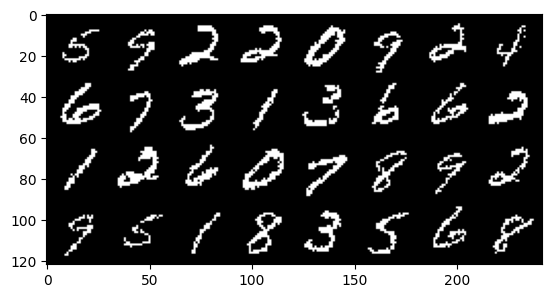

In [63]:
show_and_save("real_mnist",make_grid(v.view(-1,1,28,28).data))

torch.Size([3, 122, 242])


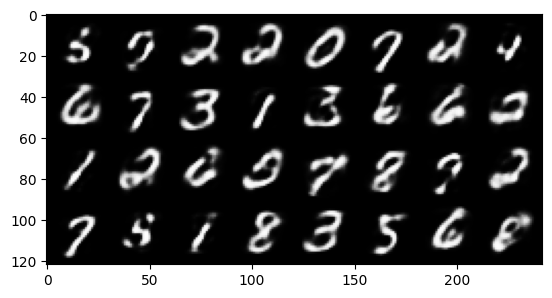

In [64]:
show_and_save("generate_mnist",make_grid(p_v.view(-1,1,28,28).data))

torch.Size([3, 212, 242])


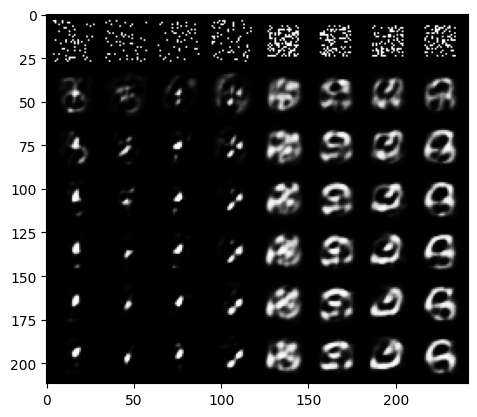

In [65]:
n_sample, n_it = 8, 2*n_it_training
data = torch.from_numpy(np.zeros((n_it+1, 8, 784)).astype(np.single))

starting_data = np.zeros((8, 28, 28))
starting_data[0:4, 2:26, 2:26] = np.random.rand(4, 24, 24) > 0.9
starting_data[4:8, 5:23, 5:23] = np.random.rand(4, 18, 18) > 0.7

data[0, :, :] = torch.from_numpy(starting_data.reshape(8, 784).astype(np.single))

h_ = rbm_mnist.v_to_h(data[0, :, :])
for i in range(n_it):
    v_,p_v = rbm_mnist.h_to_v(h_)
    h_     = rbm_mnist.v_to_h(v_)
    data[i+1, :, :] = p_v

show_and_save("generate_mnist_steps", make_grid(data.data.view(-1,1,28,28)))

In [8]:
# # Accumulate batches into a single tensor
# data = torch.cat([batch for _,(batch,_) in enumerate(train_loader)])
# data_flatten = data.view(data.size(0), -1)

# # generate a trajectory
# trajectory = torch.tensor(data.view(data.size(0),-1)[0,:].view(1,-1))
# v = data.view(-1,784)[0,:]

# N_steps=10
# h = rbm.v_to_h(v)
# p = torch.ones(size=[N_steps])
# lpr = torch.ones(size=[N_steps])
# a = p.log().sum()
# a = p1
# ar = p[-1]
# ar = p1
# for i in range(1,N_steps):
#     v, p = rbm.h_to_v(h)
#     h = rbm.v_to_h(v)
#     trajectory = torch.cat([v.view(1,-1),trajectory])
#     a = p[i]
#     b = p[i-1]
#     a = b*p1.prod()*p2.prod()

#     ar = p[-(i+1)]
#     br = p[-(i)]
#     ar = br * p1.prod() * p2.prod()

# # Ent_temp = p.div(pr).log().mul(p)
# # Ent = torch.cumsum(Ent_temp,0)

# # Center the data
# data_mean = torch.mean(data_flatten, dim=0)
# centered_data = data_flatten - data_mean

# # centered trajectory
# traj_mean = torch.mean(trajectory, dim=0)
# centered_trajectory = trajectory - traj_mean

# # Compute the SVD (Singular Value Decomposition)
# U, S, V = torch.pca_lowrank(centered_data, center=True)

# # Choose the top k singular vectors (in this case, k=2 for 2D projection)
# k = 2
# projection_matrix = V[:, :k]

# # Project the data onto the top k singular vectors
# pca_result = torch.matmul(centered_data, projection_matrix)
# pca_trajectory = torch.matmul(centered_trajectory, projection_matrix)

# # Convert the result to numpy for plotting
# pca_result_np = pca_result.numpy()
# pca_trajectory_np = pca_trajectory.detach().numpy()


In [9]:
# # Plotting the results
# plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 1)
# plt.scatter(data_flatten[:,0], data_flatten[:,1], alpha=0.5)
# plt.scatter(trajectory.detach().numpy()[:,0], trajectory.detach().numpy()[:,1], alpha=0.5)
# plt.title('Original Data')

# plt.subplot(1, 2, 2)
# plt.scatter(pca_result_np[:, 0], pca_result_np[:, 1], alpha=0.5)
# color_map = range(0,N_steps)
# plt.scatter(pca_trajectory_np[:,0], pca_trajectory_np[:,1], c=color_map, cmap=cm.gnuplot, alpha=0.2)
# plt.title('PCA Projection')

# plt.show()

## Test on pfashion mnist

In [10]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
datasets.FashionMNIST('./dataFashion',
    train=True,
    download = True,
    transform = transforms.Compose(
        [transforms.ToTensor()])
     ),
     batch_size=batch_size
)

test_loader = torch.utils.data.DataLoader(
datasets.FashionMNIST('./dataFashion',
    train=False,
    transform=transforms.Compose(
    [transforms.ToTensor()])
    ),
    batch_size=batch_size)



In [12]:
n_it_training = 2

rbm_fashion = RBM(784, 500, n_it_training)
train_op = optim.SGD(rbm_fashion.parameters(),0.01)
losses=[]

n_epochs, n_batch = 40, 500
for epoch in range(n_epochs):
    loss_ = []
    for i, (data,target) in enumerate(train_loader):
        data = Variable(data.view(-1,784))
        sample_data = data.bernoulli()

        sample_data = rbm_fashion.sample_from_p(sample_data.flatten()).reshape(sample_data.shape)
        
        v,v1,p_v = rbm_fashion(sample_data)
        loss = rbm_fashion.free_energy(v) - rbm_fashion.free_energy(v1)
        loss_.append(loss.data)
        train_op.zero_grad()
        loss.backward()
        train_op.step()

        if i >= n_batch and n_batch > 0:
            break
    
    losses.append(np.mean(loss_))
    print("Training loss for {} epoch: {}".format(epoch, np.mean(loss_)))

Training loss for 0 epoch: -27.234079360961914
Training loss for 1 epoch: -20.92083740234375
Training loss for 2 epoch: -20.03010368347168
Training loss for 3 epoch: -18.7060489654541
Training loss for 4 epoch: -17.666046142578125
Training loss for 5 epoch: -16.932771682739258
Training loss for 6 epoch: -16.210941314697266
Training loss for 7 epoch: -15.597558975219727
Training loss for 8 epoch: -15.243831634521484
Training loss for 9 epoch: -14.631823539733887
Training loss for 10 epoch: -13.908639907836914
Training loss for 11 epoch: -13.045953750610352
Training loss for 12 epoch: -12.950580596923828
Training loss for 13 epoch: -12.074273109436035
Training loss for 14 epoch: -11.648521423339844
Training loss for 15 epoch: -11.126501083374023
Training loss for 16 epoch: -10.593329429626465
Training loss for 17 epoch: -10.078814506530762
Training loss for 18 epoch: -9.741240501403809
Training loss for 19 epoch: -9.324984550476074
Training loss for 20 epoch: -8.767736434936523
Training 

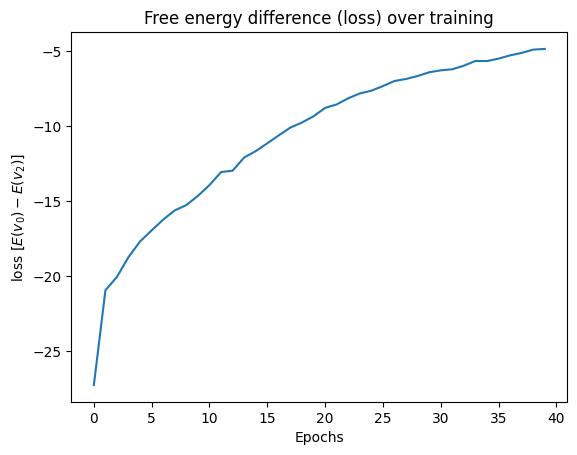

In [27]:
plt.plot(losses)
plt.title("Free energy difference (loss) over training")
plt.xlabel("Epochs")
plt.ylabel(rf"loss [$E(v_0) - E(v_{ n_it_training })$]")
plt.plot()
plt.savefig('free_energy_fashion.png')

torch.Size([3, 122, 242])


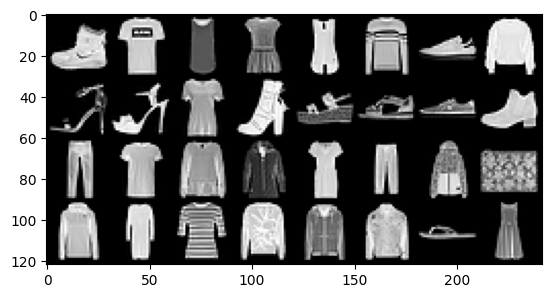

In [25]:
show_and_save("real_fashion", make_grid(data.data.view(-1,1,28,28)))

torch.Size([3, 122, 242])


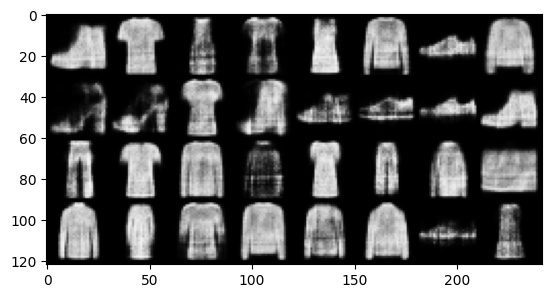

In [26]:
show_and_save("generate_fashion", make_grid(p_v.data.view(-1,1,28,28)))

torch.Size([3, 212, 242])


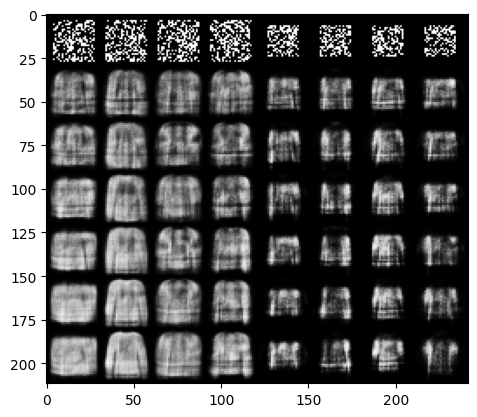

In [58]:
n_sample, n_it = 8, 2*n_it_training
data = torch.from_numpy(np.zeros((n_it+1, 8, 784)).astype(np.single))

starting_data = np.zeros((8, 28, 28))
starting_data[0:4, 2:26, 2:26] = np.random.rand(4, 24, 24) > 0.6
starting_data[4:8, 5:23, 5:23] = np.random.rand(4, 18, 18) > 0.6

data[0, :, :] = torch.from_numpy(starting_data.reshape(8, 784).astype(np.single))

h_ = rbm_fashion.v_to_h(data[0, :, :])
for i in range(n_it):
    v_,p_v = rbm_fashion.h_to_v(h_)
    h_     = rbm_fashion.v_to_h(v_)
    data[i+1, :, :] = p_v

show_and_save("generate_fashion_steps", make_grid(data.data.view(-1,1,28,28)))

In [16]:
# # Continuous RBM
# class RBM_C(nn.Module):

#     def __init__(self,
#                 n_vis=784,
#                 n_hin=500,
#                 k=5):
#         torch.set_default_dtype(torch.double)
#         super(RBM_C, self).__init__()
#         self.W = nn.Parameter(torch.randn(n_hin,n_vis)*1e-2)
#         self.v_bias = nn.Parameter(torch.zeros(n_vis))
#         self.h_bias = nn.Parameter(torch.zeros(n_hin))
#         self.k = k
#         self.eps=1e-18

#     def p_h(self, h, v):
#         norm = F.linear(v, self.W, self.h_bias)
#         exponent = torch.mul( h, norm)
#         num = torch.mul(torch.exp( exponent ), norm)
#         #print('p_h_num',num)
#         return torch.prod(torch.div( num, torch.exp( norm)))
    
#     def p_v(self, v, h):
#         norm = F.linear( h, self.W.t(), self.v_bias)
#         exponent = torch.mul(v, norm)
#         num = torch.mul( torch.exp( exponent ), norm)
#         return torch.prod(torch.div(num, torch.exp(norm).add(self.eps)))

#     def v_to_h(self,v):
#         # sample the configurations using the Box-Mueller algorithm
#         y = Variable(torch.rand(self.h_bias.size()))
#         norm = F.linear(v,self.W,self.h_bias)
#         #norm_inv = torch.div(torch.ones_like(norm), norm)
#         log_term = torch.log(torch.matmul(torch.exp(norm), y).add(1))
#         h = (log_term.div(norm.t().add(self.eps))).t()
#         #print('shape_h:',h.shape)
#         # compute the probability of the configuration
#         p_h = self.p_h(h, v)

#         return p_h, h
    
#     def h_to_v(self, h):
#         # sample the configurations using the Box-Mueller algorithm
#         y = Variable(torch.rand(self.v_bias.size()))
#         norm = F.linear(h, self.W.t(), self.v_bias)
#         print("norm:", norm)
#         #norm_inv = torch.div(torch.ones_like(norm), norm)
#         log_term = torch.log(torch.mul(torch.exp(norm),y).add(1))
#         v = log_term.div(norm.add(self.eps))
#         #print('v_shape:',v.shape)
#         # compute the probability
#         p_v = self.p_v(v,h)

#         return p_v, v

        
#     def forward(self,v):
#         #print('batch_shape',v.shape)
#         pre_h1,h1 = self.v_to_h(v)
        
#         h_ = h1
#         for _ in range(self.k):
#             pre_v_,v_ = self.h_to_v(h_)
#             #print(pre_v_, v_)
#             pre_h_,h_ = self.v_to_h(v_)
#             #print(pre_h_.shape, v.shape)
        
#         return v,v_,h1,h_

#     def free_energy(self,v):
#         free =  - torch.sum(torch.matmul(v, self.v_bias)) - torch.trace(torch.matmul( F.linear(v, self.W), F.linear( v, self.W ).t() ))
#         return free
    
#     def gradient_step(self, v0, v1, h0, h1, lr=0.01, momentum=0.01):
#         grad_W = torch.matmul(h0.t(),v0).div(v0.shape[0]) - torch.matmul(h1.t(),v1).div(v1.shape[0])
#         grad_h_bias = h0.mean(dim=0) - h1.mean(dim=0)
#         grad_v_bias = v0.mean(dim=0) - v1.mean(dim=0)

#         W_ = self.W
#         h_bias_=self.h_bias
#         v_bias_=self.v_bias
#         # self.W =  nn.Parameter(W_ - torch.mul(lr ,grad_W))
#         # self.h_bias =  nn.Parameter(h_bias_ - torch.mul(lr, grad_h_bias))
#         # self.v_bias = nn.Parameter(v_bias_ - torch.mul(lr, grad_v_bias))

#         return self.free_energy(v)

In [17]:
# rbm = RBM_C(k=1)
# train_op = optim.SGD(rbm.parameters(),0.01)
# losses=[]
# #optim = torch.optim.SGD(rbm.parameters(), lr=1e-2, momentum=0.9)

# for epoch in range(10):
#     loss_ = []
#     for _, (data,_) in enumerate(train_loader):
#         data = Variable(data.view(-1,784))
#         sample_data = data.bernoulli()
        
#         v,v1, h, h1 = rbm(sample_data)
        
#         # with torch.no_grad.:
#         loss = rbm.gradient_step(v, v1, h, h1)
#         loss_.append(loss.data)
#         #print(loss)
#         # grad_W = torch.autograd.backward(loss, rbm.W)
#         # grad_h_bias = torch.autograd.backward(loss, rbm.h_bias)
#         # grad_v_bias = torch.autograd.backward(loss, rbm.v_bias)
        
#         train_op.zero_grad()
#         loss.backward()
#         train_op.step()

#     losses.append(np.mean(loss_))
#     print("Training loss for {} epoch: {}".format(epoch, np.mean(loss_)))